In [ ]:
from cellmech import *
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# open microfscopic image of cell and convert it into matrix
image_matrix = np.array(Image.open('../images/cell_boundary/img2.png').convert('L'))
image_dim = np.shape(image_matrix)

# define all the parameters that are required to calculata traction forces
cellmechparams = CellMechParameters({
    "p" : 0.5,
    "E" : 10e3,
    "pi" : np.pi,
    "N" : 20,
    "width" :2,
    "pixel_size" : 1e-7 
})

'''
first we will a dummy force field using known function (symmetric gausian) to calcualte displacement field, then we will 
use generated dispclement field to retrieve original force field so see if calculations match 
'''

# force_points, updated_image = detect_shapes(image_matrix, detection_threshold = 0.7)
force_points, updated_image = detect_shapes_canon(image_matrix, detection_threshold = 0.7)

np.save('../data/force_points.npy', np.array(force_points))
saved = np.load('../data/force_points.npy')
# calculation of force field using gaussian
force_field  = calculate_dummy_force(force_points, cellmechparams)

x_axis = np.linspace(-1, 1, updated_image.shape[0])
y_axis = np.linspace(-1, 1, updated_image.shape[1])

central point of all forces [-1.30104261e-18  8.32667268e-17]


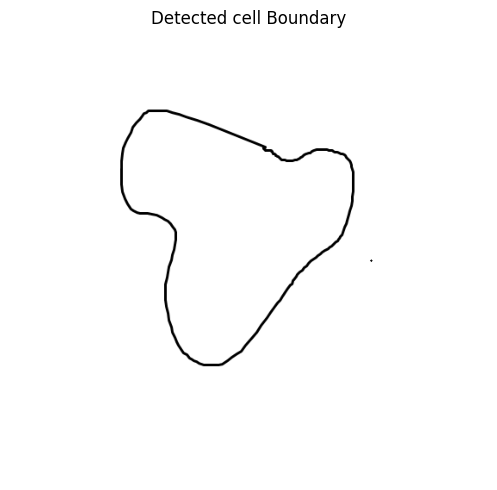

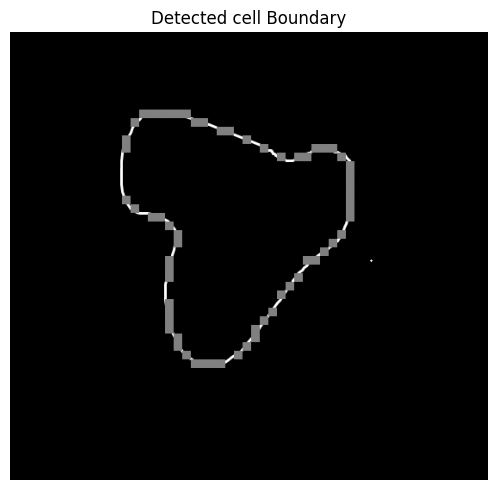

In [3]:
view_cell_image(image_matrix)
view_cell_image(updated_image)
# plt.plot(force_points[:,0], force_points[:,1])
# plt.title("Cell boundary and force points")

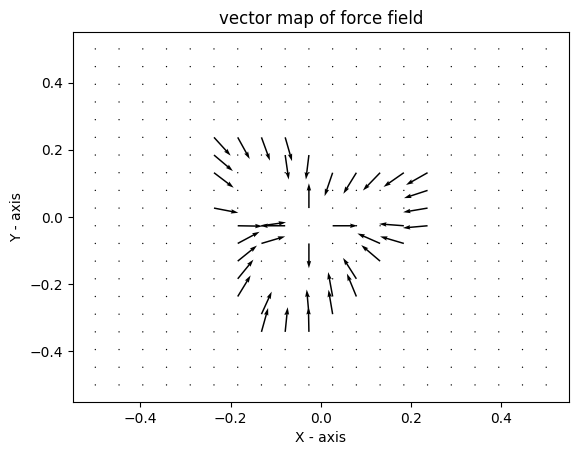

In [4]:
# visualzation of force of displacement using FTTC and tensor network contraction
# print(force_field)
fig = plot_vector_field(force_field, "vector map of force field")

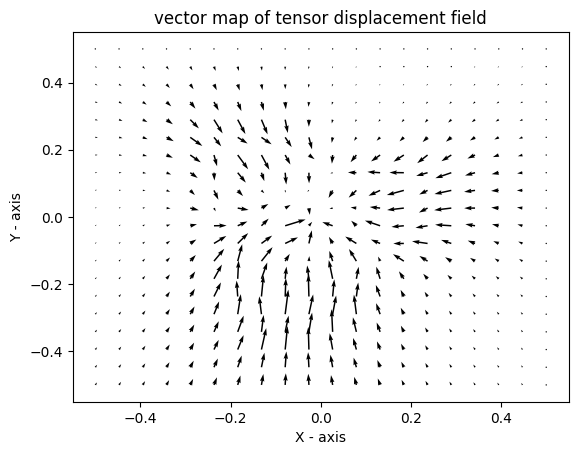

In [5]:
# calculation of displacement using FTTC and tensor network contraction
displacement = calculate_displacement(force_field, cellmechparams, "tn")

fig = plot_vector_field(displacement, "vector map of tensor displacement field")

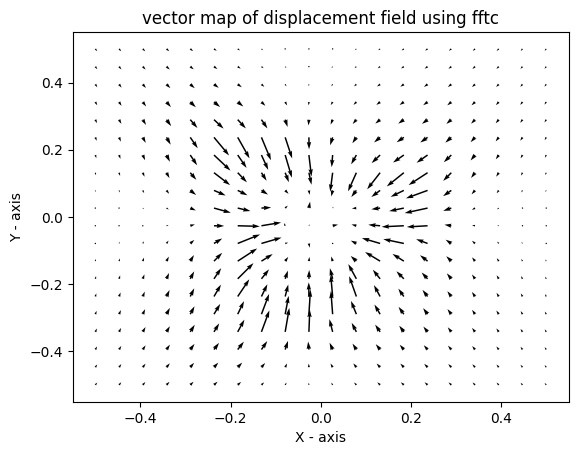

In [6]:
dx = cellmechparams.params["width"]/cellmechparams.params["N"]
displacement = calculate_displacement(force_field/dx**2, cellmechparams)
fig = plot_vector_field(displacement, "vector map of displacement field using fftc")

Text(0.5, 1.0, 'Absolute displacement (micro-meters)')

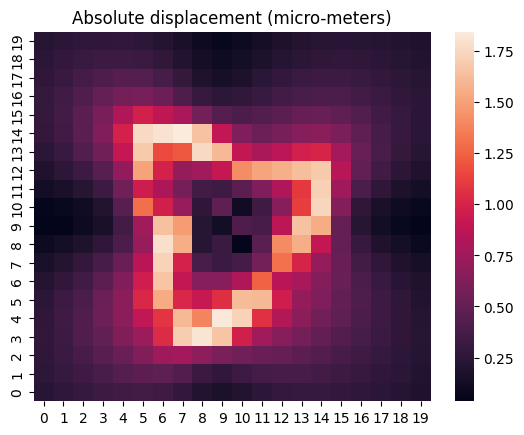

In [7]:

fmag = np.sqrt(displacement[:,:,0]**2 + displacement[:,:,1]**2)
ax = sns.heatmap(np.transpose(fmag * 1e6)) # converting tp micro meters
ax.invert_yaxis()
plt.title("Absolute displacement (micro-meters)")

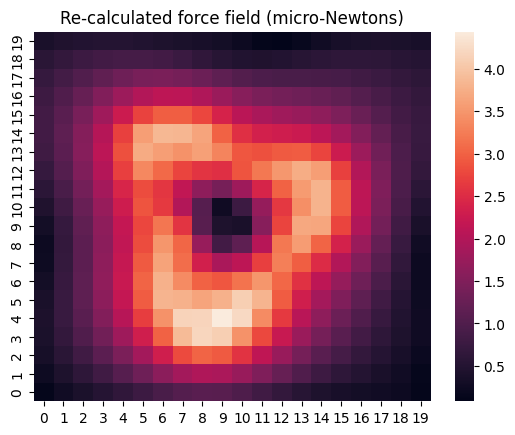

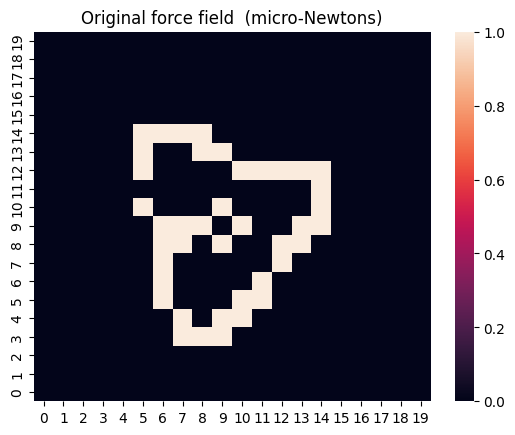

percentage error :  1503.0757850549317 %


In [8]:
'''
Now to back calculate force field from displacement field
'''

recalc_force_field = calculate_traction_force(displacement, cellmechparams)

recalc_force_field_mag = np.sqrt(recalc_force_field[:,:,0]**2 + recalc_force_field[:,:,1]**2)
ax = sns.heatmap(np.transpose(recalc_force_field_mag * 1e6)) # converting to micro newtons
ax.invert_yaxis()
plt.title("Re-calculated force field (micro-Newtons)")
plt.show()

force_field_mag = np.sqrt(force_field[:,:,0]**2 + force_field[:,:,1]**2)
ax = sns.heatmap(np.transpose(force_field_mag * 1e6)) # converting to micro newtons
ax.invert_yaxis()
plt.title("Original force field  (micro-Newtons)")
plt.show()

#  re-scaling of force magnitude values (note the denominator is same for both re-calculated and original)
np.save('../data/force_field.npy', force_field_mag)
print("percentage error : ", 100*np.mean(abs(force_field_mag - recalc_force_field_mag))/np.mean(abs(force_field_mag)), "%")